---
# **Sentiment Analysis**: Sentiment Analysis on GameSphere Game Reviews
---
## **Problem Statement**:


- GameSphere, a premier digital distribution platform for video games, stands at the forefront of the gaming industry by bridging a global community of gamers.
- It hosts a vast collection of games, encouraging users to leave reviews and share recommendations within the community.
- These reviews are crucial for feedback to developers and guide potential buyers in their decisions.
- Automatically analyzing and classifying the sentiment of these reviews as positive (recommended) or negative (not recommended) can offer invaluable insights into a game's acceptance and its overall standing among users.

## **Aim**:
- The main objective of this project is to build a smart model that can correctly figure out what a review is saying about a game on GameSphere.
- The model will look at the review text and other game info to decide if a review recommends the game. Moreover, the model will calculate **how likely a review is to be positive**.
- This detailed approach helps GameSphere better understand and organize game reviews from the internet, giving a clearer view of how popular and well-received games are.
- By doing this, we're not just seeing if people like a game but how much they like it, making our analysis more precise.


## **Dataset Attributes**:


- **review_id**: A unique identifier for each review, used to distinguish between different reviews.
- **title**: The name of the game that the review is about.
- **developer**: The name of the company or individual who developed the game.
- **publisher**: The name of the company that published the game, making it available to the public.
- **tags**: A list of categories or genres associated with the game, such as 'Free to Play', 'Strategy', 'Multiplayer', etc., which give a general idea of the game's nature.
- **overview**: A brief description or summary of the game, providing insight into its content or storyline.
- **year**: The year in which the game was released, indicating its age.
- **user_review**: The actual text of the user's review, where the reviewer shares their thoughts and opinions about the game.
- **sentiment**: Indicates the reviewer's overall sentiment towards the game, categorized as 'Positive' or 'Negative'.

- **PositiveSentimentProbability**: This is the target variable and it represents the probability that a game review expresses a positive sentiment towards the game. A probability closer to 0 indicates that the sentiment will be negative and a probability closer to 1 indicates a positive sentiment.

### **Hint**: **PositiveSentimentProbability** variable is not in the dataset. You simply have to predict the probability of the positive class (Using your best chosen model) and return that probability as your final submission.



---
# **Load dataset**
---

### Import Libraries

In [43]:
import numpy as np
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,roc_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re
import string
from nltk.corpus import stopwords
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

In [3]:
# Load the dataset

game_reviews_df=pd.read_csv('C:\\Users\\kumarip\\Documents\\Priya\\final\\final\\Problem1\\data\\train.csv', converters={'tags':literal_eval})
game_reviews_df.head()

,review_id,title,developer,publisher,tags,overview,year,user_review,sentiment
0,4848,SMITE®,Titan Forge Games,Hi-Rez Studios,"[Free to Play, MOBA, Multiplayer, Action, Thir...",Enter the Battleground of the GodsJoin the mil...,2016.0,"I've played this game since before beta ended,...",Positive
1,15427,Business Tour - Board Game with Online Multipl...,Creobit,8Floor,"[Free to Play, Board Game, Strategy, Massively...","""Business Tour"" simple and entertaining gamepl...",2018.0,"fun little game , but you really need to put a...",Positive
2,8236,Neverwinter,Cryptic Studios,Perfect World Entertainment,"[Free to Play, MMORPG, RPG, Massively Multipla...",,2014.0,First of all this is not a pay to win game. ZE...,Positive
3,3805,Team Fortress 2,Valve,Valve,"[Free to Play, Multiplayer, FPS, Action, Shoot...","""The most fun you can have online"" - PC GamerI...",2014.0,this game have all very funny and tactical...,Positive
4,17261,School of Dragons,"JumpStart Games, Inc.","JumpStart Games, Inc.","[Free to Play, Dragons, Adventure, Multiplayer...",**Changewing Dragon now Available**Fly Fast. T...,2017.0,"This is a great game, it really is. I understa...",Positive


---
# **Questions**
---
**Instructions:**
1.  Answer all questions.
2.  Justify your answers with appropriate reasoning, code, or calculations.
3.  Ensure your code is well-commented to explain your logic.
4.  Total Marks: 100

## **Question 1 : Data Analysis** (10 pt)
Summarize the data:
- How much data is present?
- What attributes/features are continuous valued?
- Which attributes are categorical?
- Which attributes have a lot of text?
- Explain noticeable traits for key attributes. Check distribution of the sentiment attribute.
- Are there any attributes that might require special treatment? If so, what special treatment might they require?
- Analyze and discuss the relationships between the data attributes, and between the data attributes and label.
- Analyze the relationship between all the features. Use appropriate visualization techniques.
- If there is a lot of textual information, how much count certain text-heavy attributes have.
- Try using word-clouds to analyze text data.

In [4]:
game_reviews_df.shape

(17319, 9)

> There are 17319 rows and 9 columns

In [5]:
game_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17319 entries, 0 to 17318
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    17319 non-null  int64  
 1   title        17319 non-null  object 
 2   developer    17319 non-null  object 
 3   publisher    17319 non-null  object 
 4   tags         17319 non-null  object 
 5   overview     17319 non-null  object 
 6   year         17141 non-null  float64
 7   user_review  17319 non-null  object 
 8   sentiment    17319 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 1.2+ MB


> The above shows that 'year' column is continuous for this context while the remaining  are categorical.Although  'review_id' is represented as int , it is categorical due to its nature as a unique identifier for each review entry.

It seems that overview, tags and user_review contain substantial amount of text. let's calculate their average length 

In [6]:
len_overview=game_reviews_df['overview'].str.len()
len_review=game_reviews_df['user_review'].str.len()
len_tags=game_reviews_df['tags'].str.len()

print('Average Length of overview column',len_overview.mean())
print('Average Length of review column',len_review.mean())
print('Average Length of tags column',len_tags.mean())

Average Length of overview column 1775.1235059760957
Average Length of review column 761.6675905075351
Average Length of tags column 18.65840983890525


> Overview and user_review columns have a lot of text

In [7]:
game_reviews_df.isnull().sum()

review_id        0
title            0
developer        0
publisher        0
tags             0
overview         0
year           178
user_review      0
sentiment        0
dtype: int64

> 'year' column contains null values which should be handled

In [8]:
game_reviews_df.drop(columns = ['tags']).duplicated().sum()

0

>There are no duplicate values

In [9]:
game_reviews_df['sentiment'].value_counts()

sentiment
Positive    9868
Negative    7451
Name: count, dtype: int64

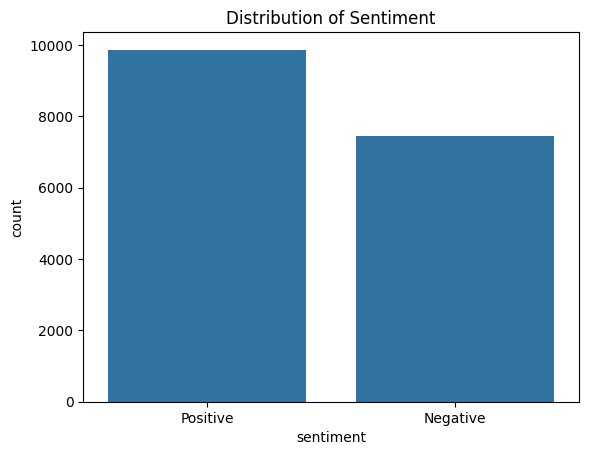

In [10]:
sns.countplot(x='sentiment', data=game_reviews_df)
plt.title('Distribution of Sentiment')
plt.show()

>We need to preprocess the 'sentiment' attribute by encoding its values to 0 and 1, where 0 represents negative sentiment and 1 represents positive sentiment. Additionally, the dataset requires balancing the distribution of sentiment classes using oversampling techniques.

In [11]:
print(game_reviews_df['user_review'][2])
game_reviews_df['overview'][1]

First of all this is not a pay to win game. ZEN is a currency you can buy with real money. You can convert ZEN into Astral Diamonds or do the opposite - AD into ZEN. AD can be achieved by doing daily quests and is the trading currency used in the Auction House and several merchants. You can buy ZEN to quicken your progression or make the game more convenient(e.g. extra inventory slots, respec tokens, rare companions and more). ZEN converted into AD can get you rare and powerful items from the Auction House. Only difference a paying user could have, is if he bought a Starter pack or Guardian of Neverwinter pack and he would receive exclusive gear, mounts/companions, enchants. They barely affect gameplay and only have vanity value, rather than becoming stronger. All content is the same either you're a paying user or a free user, it depends on how much are you willing to grind. You can grind to get AD and then trade it for something you want. Or be a bit more patient and do daily quests a

'"Business Tour" simple and entertaining gameplay allows you to come up with many interesting strategies, come to agreements with your rivals and even enter into conspiracies against other players. Apart from that, the game helps you to reveal your inner entrepreneurial qualities. For precisely this reason, children and adults alike can enjoy this game equally."Business Tour" allows you to play a classic tabletop game online with your friends. The main advantage of "Business Tour" is that it\'s easy to learn to play, but that doesn\'t mean it\'s easy to win. You\'ll have to use all your bravery and business acumen to defeat real opponents. Difficulty and unpredictability make the classic table-top game more interesting, and the gameplay more diverse.Key features: * Online multiplayer mode, 2-4 players * Offline multiplayer mode * Play with Bots * Trading Cards and Achievements * Worldwide leaderboard * Your favorite game is now online * Daily Tasks * Inventory'

> The 'user_review' and 'overview' columns contain special characters, numbers, punctuation marks, and other non-alphanumeric characters. These should to be cleaned before applying modeling process.

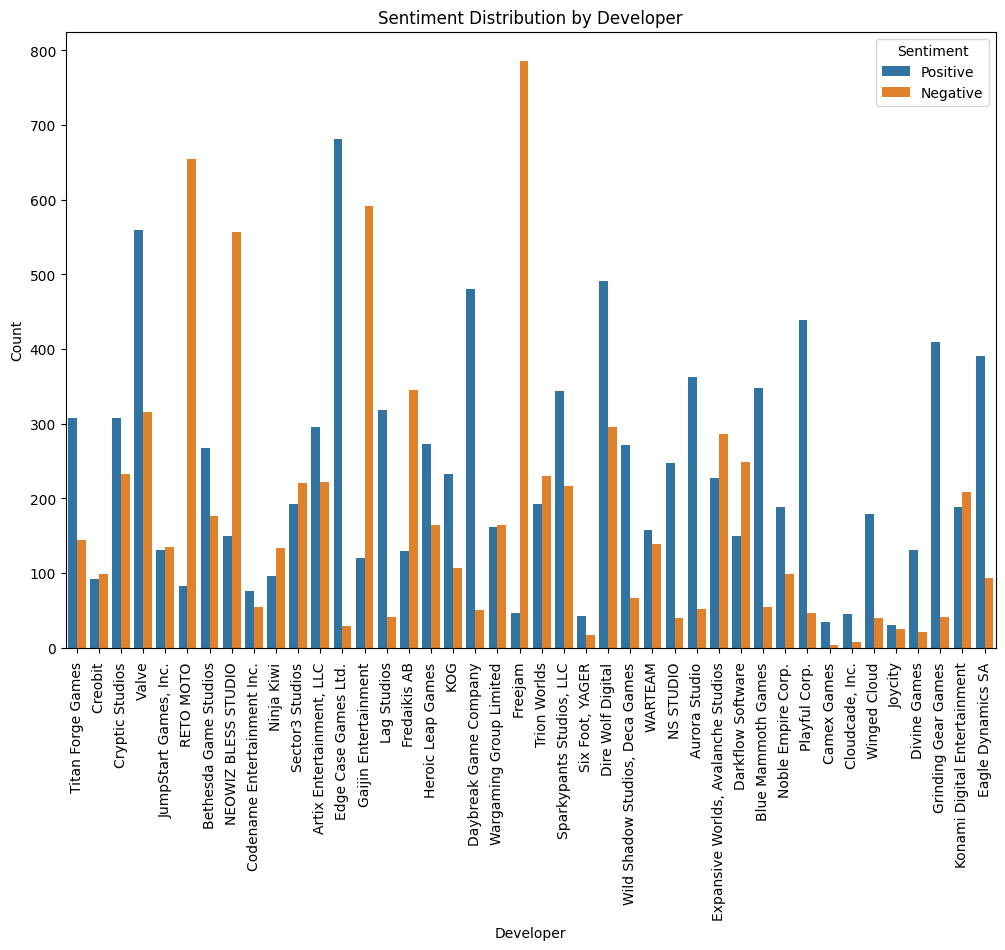

In [12]:
plt.figure(figsize=(12, 8))
sns.countplot(x='developer', hue='sentiment', data=game_reviews_df)
plt.title('Sentiment Distribution by Developer')
plt.xlabel('Developer')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Sentiment')
plt.show()

> The graph above suggests that sentiment is influenced by the developer's name. For example, games developed by Freejam and Reto Moto tend to have more negative reviews.

In [13]:
publisher_sentiment_counts = game_reviews_df.groupby(['publisher', 'sentiment']).size().unstack(fill_value=0)

publisher_total_counts = publisher_sentiment_counts.sum(axis=1)

publisher_sentiment_percentages = publisher_sentiment_counts.divide(publisher_total_counts, axis=0) * 100

print("Sentiment distribution across publishers:")
print(publisher_sentiment_percentages)

Sentiment distribution across publishers:
sentiment                                     Negative   Positive
publisher                                                        
8Floor                                       51.832461  48.167539
Artix Entertainment, LLC                     42.940039  57.059961
Bethesda Softworks                           39.104478  60.895522
Camex Games                                  10.526316  89.473684
Cloudcade, Inc.                              13.461538  86.538462
Codename Entertainment Inc.                  41.984733  58.015267
Daybreak Game Company                         9.586466  90.413534
Deca Games                                   19.526627  80.473373
Dire Wolf Digital                            37.531807  62.468193
Edge Case Games Ltd.                          4.078762  95.921238
Expansive Worlds, Avalanche Studios          55.750487  44.249513
Fredaikis AB                                 72.784810  27.215190
Freejam                           

>The data indicates that games from publishers like Freejam, Fredaikis AB, and RETO MOTO exhibit higher negative sentiment. This suggests a necessity for these publishers to address potential issues or concerns associated with their games to enhance user satisfaction.

In [14]:
publisher_sentiment_counts = game_reviews_df.groupby(['year', 'sentiment']).size().unstack(fill_value=0)
publisher_total_counts = publisher_sentiment_counts.sum(axis=1)

publisher_sentiment_percentages = publisher_sentiment_counts.divide(publisher_total_counts, axis=0) * 100

print("Sentiment distribution across publishers:")
print(publisher_sentiment_percentages)

Sentiment distribution across publishers:
sentiment   Negative   Positive
year                           
2011.0      7.692308  92.307692
2012.0      3.125000  96.875000
2013.0     19.526627  80.473373
2014.0     37.947333  62.052667
2015.0     29.373208  70.626792
2016.0     49.366786  50.633214
2017.0     40.612828  59.387172
2018.0     49.832215  50.167785


In [15]:
game_reviews_df['tags'][0]

['Free to Play',
 'MOBA',
 'Multiplayer',
 'Action',
 'Third Person',
 'Mythology',
 'Team-Based',
 'Competitive',
 'Strategy',
 'Co-op',
 'PvP',
 'Massively Multiplayer',
 'RPG',
 'e-sports',
 'MMORPG',
 'Adventure',
 'Funny',
 'Survival',
 'Nudity',
 'Casual']

>This attribute contains a list of tags.Special treatmnet is needed to extract individual tags from the list .

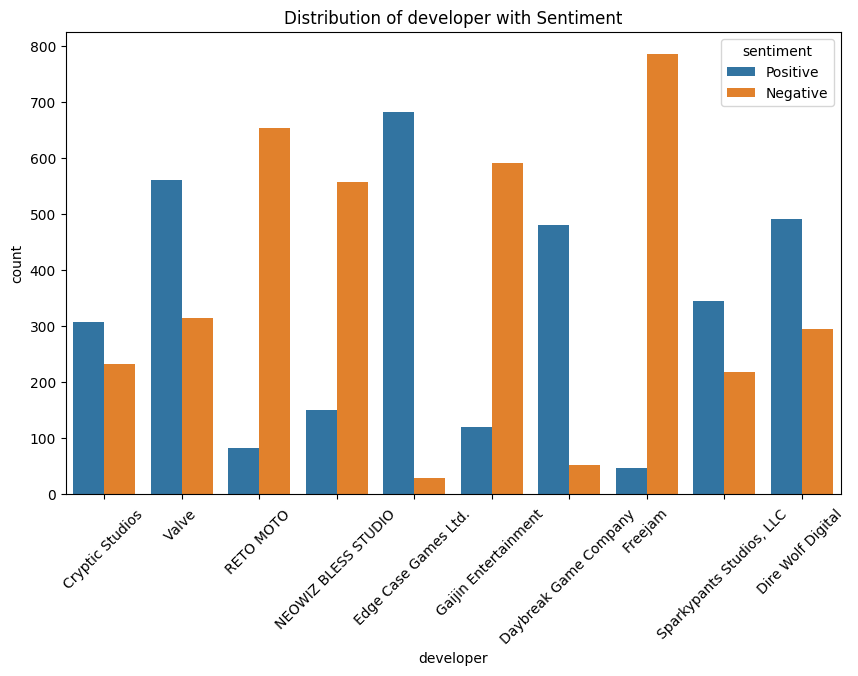

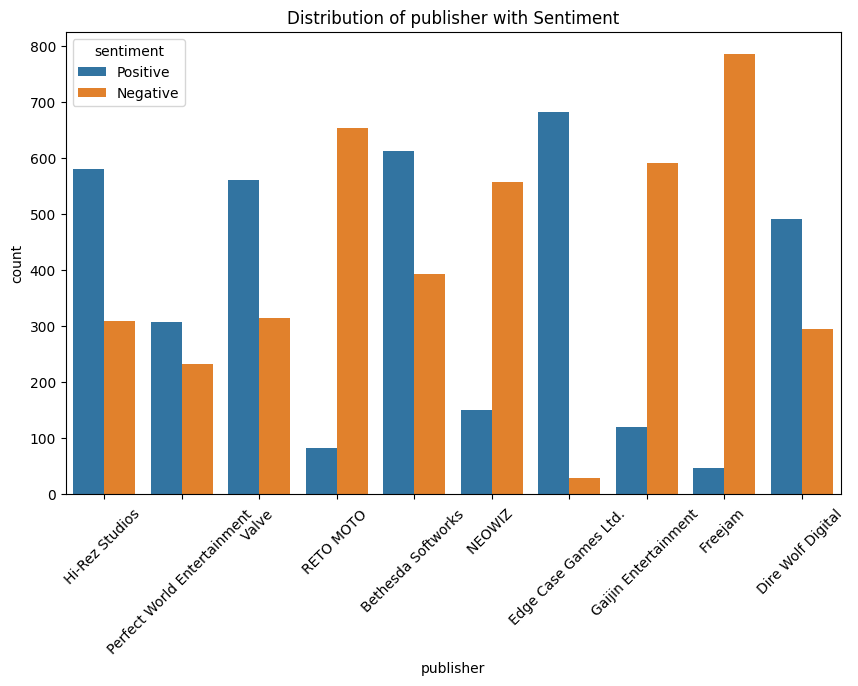

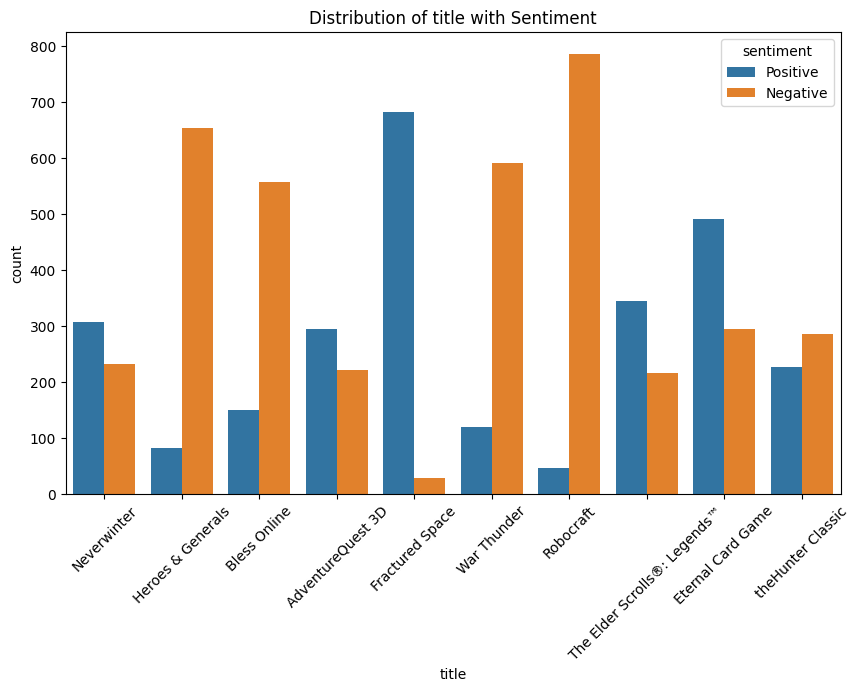

In [16]:
# Get the top 10 most frequent values for each categorical feature
top_title = game_reviews_df['title'].value_counts().nlargest(10).index
top_publisher = game_reviews_df['publisher'].value_counts().nlargest(10).index
top_developer = game_reviews_df['developer'].value_counts().nlargest(10).index

# Bar plots for top 10 categorical features with sentiment as hue
for feature, top_values in [('developer', top_developer), ('publisher', top_publisher), ('title', top_title)]:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=game_reviews_df[game_reviews_df[feature].isin(top_values)], x=feature, hue='sentiment')
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {feature} with Sentiment')
    plt.show()


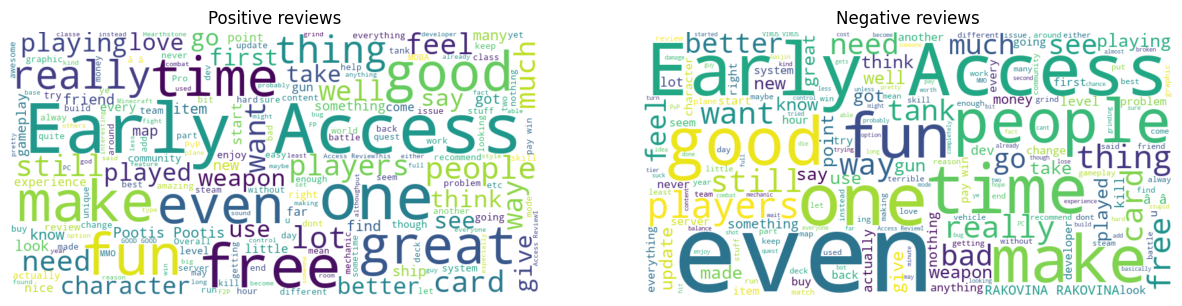

In [17]:
# wordcloud
tokenizer = nltk.tokenize.WordPunctTokenizer()
stopword_list = set(stopwords.words('english'))
custom_stop_words = set(["game", "nope", "games", 'play', 'player']) #remove common repetitive words from the list
stopword_list.update(custom_stop_words)

def remove_stopwords(text, tokenizer, stopword_list, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

game_reviews_df['user_review'] = game_reviews_df['user_review'].apply(remove_stopwords, args=(tokenizer, stopword_list))
from wordcloud import WordCloud
positive_text= " ".join(game_reviews_df[game_reviews_df['sentiment']=='Positive']['user_review'])
negative_text= " ".join(game_reviews_df[game_reviews_df['sentiment']=='Negative']['user_review'])
wordcloud_pos= WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg= WordCloud(width=800, height=400, background_color='white').generate(negative_text)
wordcloud_pos_arr=wordcloud_pos.to_array()
wordcloud_neg_arr=wordcloud_neg.to_array()

fig,axes=plt.subplots(1,2,figsize=(15,7))
axes[0].imshow(wordcloud_pos_arr,interpolation='bilinear')
axes[0].set_title('Positive reviews')
axes[0].axis('off')
axes[1].imshow(wordcloud_neg_arr,interpolation='bilinear')
axes[1].set_title('Negative reviews')
axes[1].axis('off')
plt.show()

## **Question 2 : Data Pre-processing & Feature Engineering** (20 pt)
- Discuss the steps you would take to clean and prepare the data for modeling. Justify why each step is necessary.
- Perform Feature Engineering on the dataset. Since this is a text-heavy dataset, you have to tokenize and pre-process the text data.

**Hints**:
- Check for any null values or duplicate rows in the dataset and perform necessary actions. Also, encoding categorical columns properly.
- Primary goal is to analyze reviews to predict sentiment. Such data requires a lot of pre-processing.
- You can start with using **regular expressions** to remove **links**, **HTML tags**, **unnecessary punctuation**, **emojis** (if any), etc.
- You can remove **stopwords** with very high or very low frequency across the reviews.
- You can also perform some advance techniques like **stemming** or **lemmatization** to further remove reduncancies.
- For feature engineering, you can use other techniques such as "**counter vectorization**" and "**tf-idf vectorization**" before modeling.

**Null value treatment**

In [18]:
mean_year=game_reviews_df['year'].mean()
game_reviews_df['year'].fillna(mean_year,inplace=True)


In [19]:
game_reviews_df.isnull().sum()

review_id      0
title          0
developer      0
publisher      0
tags           0
overview       0
year           0
user_review    0
sentiment      0
dtype: int64

**Encoding sentiment column**

In [20]:
game_reviews_df['sentiment']=game_reviews_df['sentiment'].map({'Positive':1, 'Negative':0})
game_reviews_df.head()

,review_id,title,developer,publisher,tags,overview,year,user_review,sentiment
0,4848,SMITE®,Titan Forge Games,Hi-Rez Studios,"[Free to Play, MOBA, Multiplayer, Action, Thir...",Enter the Battleground of the GodsJoin the mil...,2016.0,"' played since beta ended , ' pretty addicted ...",1
1,15427,Business Tour - Board Game with Online Multipl...,Creobit,8Floor,"[Free to Play, Board Game, Strategy, Massively...","""Business Tour"" simple and entertaining gamepl...",2018.0,"fun little , really need put vote kick option ...",1
2,8236,Neverwinter,Cryptic Studios,Perfect World Entertainment,"[Free to Play, MMORPG, RPG, Massively Multipla...",,2014.0,First pay win . ZEN currency buy real money . ...,1
3,3805,Team Fortress 2,Valve,Valve,"[Free to Play, Multiplayer, FPS, Action, Shoot...","""The most fun you can have online"" - PC GamerI...",2014.0,"funny tactical want , playing like 6 months ev...",1
4,17261,School of Dragons,"JumpStart Games, Inc.","JumpStart Games, Inc.","[Free to Play, Dragons, Adventure, Multiplayer...",**Changewing Dragon now Available**Fly Fast. T...,2017.0,"great , really . understand membership thing ,...",1


**Remove urls, punctuation, numerial values etc**

In [21]:
def clean_text(text):
    # Convert text to lowercase
    lower_text = text.lower()
    # Remove numerical values
    remove_numerical_values = re.sub(r'\d+', '', lower_text)
    # Remove special characters
    special_char = re.sub(r'[^\w\s]', '', remove_numerical_values)
    # Strip whitespace
    whitespace_stripping = special_char.strip()
    # Remove URLs
    remove_urls = re.sub(r'http\S+', '', whitespace_stripping)
    # Remove HTML tags
    remove_html = re.sub(r'<.*?>', '', remove_urls)
    # Remove punctuation
    remove_punctuation = remove_html.translate(str.maketrans('', '', string.punctuation))
    return remove_punctuation
    remove_emojis= ' '.join(char for char in remove_punctuation if chr not in emoji.UNICODE_EMOJI)


game_reviews_df['user_review_clean'] = game_reviews_df['user_review'].apply(clean_text)
game_reviews_df['title_clean'] = game_reviews_df['title'].apply(clean_text)
game_reviews_df['publisher_clean'] = game_reviews_df['publisher'].apply(clean_text)
game_reviews_df['overview_clean'] = game_reviews_df['overview'].apply(clean_text)
game_reviews_df['developer_clean'] = game_reviews_df['developer'].apply(clean_text)

In [22]:
game_reviews_df.head()

,review_id,title,developer,publisher,tags,overview,year,user_review,sentiment,user_review_clean,title_clean,publisher_clean,overview_clean,developer_clean
0,4848,SMITE®,Titan Forge Games,Hi-Rez Studios,"[Free to Play, MOBA, Multiplayer, Action, Thir...",Enter the Battleground of the GodsJoin the mil...,2016.0,"' played since beta ended , ' pretty addicted ...",1,played since beta ended pretty addicted pro...,smite,hirez studios,enter the battleground of the godsjoin the mil...,titan forge games
1,15427,Business Tour - Board Game with Online Multipl...,Creobit,8Floor,"[Free to Play, Board Game, Strategy, Massively...","""Business Tour"" simple and entertaining gamepl...",2018.0,"fun little , really need put vote kick option ...",1,fun little really need put vote kick option p...,business tour board game with online multiplayer,floor,business tour simple and entertaining gameplay...,creobit
2,8236,Neverwinter,Cryptic Studios,Perfect World Entertainment,"[Free to Play, MMORPG, RPG, Massively Multipla...",,2014.0,First pay win . ZEN currency buy real money . ...,1,first pay win zen currency buy real money co...,neverwinter,perfect world entertainment,,cryptic studios
3,3805,Team Fortress 2,Valve,Valve,"[Free to Play, Multiplayer, FPS, Action, Shoot...","""The most fun you can have online"" - PC GamerI...",2014.0,"funny tactical want , playing like 6 months ev...",1,funny tactical want playing like months ever...,team fortress,valve,the most fun you can have online pc gameris n...,valve
4,17261,School of Dragons,"JumpStart Games, Inc.","JumpStart Games, Inc.","[Free to Play, Dragons, Adventure, Multiplayer...",**Changewing Dragon now Available**Fly Fast. T...,2017.0,"great , really . understand membership thing ,...",1,great really understand membership thing si...,school of dragons,jumpstart games inc,changewing dragon now availablefly fast train ...,jumpstart games inc


**Remove stopwords**

In [23]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load stopwords
stopword_list = set(stopwords.words('english'))

def remove_stopwords(text, tokenizer, stopword_list, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on review column
game_reviews_df['user_review_clean'] = game_reviews_df['user_review_clean'].apply(remove_stopwords, args=(tokenizer, stopword_list))
game_reviews_df['title_clean'] = game_reviews_df['title_clean'].apply(remove_stopwords, args=(tokenizer, stopword_list))
game_reviews_df['publisher_clean'] = game_reviews_df['publisher_clean'].apply(remove_stopwords, args=(tokenizer, stopword_list))
game_reviews_df['overview_clean'] = game_reviews_df['overview_clean'].apply(remove_stopwords, args=(tokenizer, stopword_list))
game_reviews_df['developer_clean'] = game_reviews_df['developer_clean'].apply(remove_stopwords, args=(tokenizer, stopword_list))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kumarip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kumarip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Stemming**

In [24]:
stemmer = PorterStemmer()

def stem_text(text, tokenizer, stopword_list, stemmer):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stopword_list]
    stemmed_text = ' '.join(stemmed_tokens)    
    return stemmed_text

# Apply stemming on cleaned text columns
game_reviews_df['user_review_clean'] = game_reviews_df['user_review_clean'].apply(stem_text, args=(tokenizer, stopword_list, stemmer))
game_reviews_df['title_clean'] = game_reviews_df['title_clean'].apply(stem_text, args=(tokenizer, stopword_list, stemmer))
game_reviews_df['publisher_clean'] = game_reviews_df['publisher_clean'].apply(stem_text, args=(tokenizer, stopword_list, stemmer))
game_reviews_df['overview_clean'] = game_reviews_df['overview_clean'].apply(stem_text, args=(tokenizer, stopword_list, stemmer))
game_reviews_df['developer_clean'] = game_reviews_df['developer_clean'].apply(stem_text, args=(tokenizer, stopword_list, stemmer))



After experimenting with various combinations of features, it was observed that the most effective combination for achieving the best model performance includes 'user_review' and 'developer'.

In [25]:
user_review_df= game_reviews_df[['user_review_clean','developer_clean','sentiment']]  #required final columns

In [26]:
# Divide into X and Y
X=user_review_df[['user_review_clean','developer_clean']]
y=user_review_df[['sentiment']]
X

,user_review_clean,developer_clean
0,play sinc beta end pretti addict pro first mob...,titan forg game
1,fun littl realli need put vote kick option peo...,creobit
2,first pay win zen currenc buy real money conve...,cryptic studio
3,funni tactic want play like month everi time l...,valv
4,great realli understand membership thing sinc ...,jumpstart game inc
...,...,...
17314,play roughli hour best part charact creation s...,neowiz bless studio
17315,note make sure friend best summari bootleg mon...,creobit
17316,special funni lucki friendli excit heart pump ...,valv
17317,product receiv freethi free friendli multiplay...,blue mammoth game


In [27]:
X['combined_text'] = X['user_review_clean'] + ' ' + X['developer_clean']  #combine user review and developer columns together


In [28]:
#splitting into training and test dataset
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.3,random_state=42)

**oversampling the dataset**

In [29]:
# Initialize RandomOverSampler
random_oversampler = RandomOverSampler(random_state=42)

# Resample the training data
X_train_resampled, y_train_resampled = random_oversampler.fit_resample(X_train, y_train)

In [32]:
X_train_resampled_r=X_train_resampled['combined_text']
X_test=X_test['combined_text']

In [33]:
# Define vectorizers
vectorizers = [
    ('CountVectorizer', CountVectorizer()),
    ('TfidfVectorizer', TfidfVectorizer())
]


> Apply these vectorization tehniques while building the models below in section 3

## **Question 3 : Modeling** (20 pt)

- You are supposed to train a **Logistic Regression Classifier** along with atleast two other classifiers of your choice and optimize their hyperparameters (Hint: Using GridsearchCV) to enhance performance.
- Implement a validation pipeline utilizing 5-fold cross-validation.
- For each classifier, report **F1 score**, **Precision**, **Recall**, **Accuracy**, **ROC-AUC**, and **Cross-validation** score).
- Also, for each model, **plot the ROC-AUC curve**.
- Describe and discuss your findings.

**Hint**:
- To calculate the ROC-AUC scores, you need to predict the probabilites of the classes instead of the classes themselves. You can refer to the sklearn documentation for [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for more information.

### Logistic Regression

In [35]:
logistic_regression = LogisticRegression(max_iter=1000)
pipelines = []
for vectorizer_name, vectorizer in vectorizers:
    pipeline = Pipeline([
    
        ('vectorizer', vectorizer),
        ('model', logistic_regression)
    ])
    pipelines.append((vectorizer_name, pipeline))

param_grid = {
    'model__C': [0.01, 0.1, 1,10],
    'vectorizer__max_features': [1000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
for pipeline_name, pipeline in pipelines:
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(X_train_resampled_r, y_train_resampled.values.ravel())
    results.append((pipeline_name, grid_search))

for pipeline_name, result in results:
    print(f"Results for {pipeline_name}:")
    print("Best parameters:", result.best_params_)
    print("Best estimators:", result.best_score_)
    print("\n")


Results for CountVectorizer:
Best parameters: {'model__C': 1, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}
Best estimators: 0.8740536587871308


Results for TfidfVectorizer:
Best parameters: {'model__C': 10, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}
Best estimators: 0.8760183536371304




> The above shows that the best model is tfidVectorizer with logistic regression C value as 1

In [36]:
best_linear_model = results[1][1].best_estimator_
best_linear_model

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('model', LogisticRegression(C=10, max_iter=1000))])

In [38]:
best_linear_model.fit(X_train_resampled_r, y_train_resampled.values.ravel())

cv_results_linear = cross_val_score(best_linear_model, X_train_resampled_r, y_train_resampled.values.ravel(), cv=cv, scoring='accuracy')
print("Cross-validation Score:", cv_results_linear.mean())

# Calculate test balanced accuracy on test data 
y_pred = best_linear_model.predict(X_test.values.ravel())
test_accuracy_lin = accuracy_score(y_test.values.ravel(), y_pred)
print("Test  Accuracy:", test_accuracy_lin)

print("Classification report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
roc_auc_results = {}
y_proba_lr = best_linear_model.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_results['LR'] = (fpr_lr, tpr_lr, roc_auc_lr)


Cross-validation Score: 0.8760183536371304
Test  Accuracy: 0.8562355658198614
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2200
           1       0.88      0.87      0.87      2996

    accuracy                           0.86      5196
   macro avg       0.85      0.85      0.85      5196
weighted avg       0.86      0.86      0.86      5196



### Decision Tree

In [39]:
decision_tree = DecisionTreeClassifier()

pipelines_dt = []
for vectorizer_name, vectorizer in vectorizers:
    pipeline_dt = Pipeline([
        ('vectorizer', vectorizer),
        ('model', decision_tree)
    ])
    pipelines_dt.append((vectorizer_name, pipeline_dt))

# Define parameter grid for decision tree
param_grid_dt = {
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'vectorizer__ngram_range': [(1, 1), (1, 2)]
}

results_dt = []
for pipeline_name, pipeline_dt in pipelines_dt:
    grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=cv, scoring='accuracy')
    grid_search_dt.fit(X_train_resampled_r, y_train_resampled.values.ravel())
    results_dt.append((pipeline_name, grid_search_dt))

for pipeline_name, result_dt in results_dt:
    print(f"Results for {pipeline_name}:")
    print("Best parameters:", result_dt.best_params_)
    print("Best score:", result_dt.best_score_)
    print("\n")


Results for CountVectorizer:
Best parameters: {'model__max_depth': None, 'model__min_samples_split': 5, 'vectorizer__ngram_range': (1, 2)}
Best score: 0.7912549647536249


Results for TfidfVectorizer:
Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'vectorizer__ngram_range': (1, 1)}
Best score: 0.7751023132402783




In [40]:
best_decision_tree_model = results_dt[0][1].best_estimator_
best_decision_tree_model

Pipeline(steps=[('vectorizer', CountVectorizer(ngram_range=(1, 2))),
                ('model', DecisionTreeClassifier(min_samples_split=5))])

In [41]:
best_decision_tree_model.fit(X_train_resampled_r, y_train_resampled.values.ravel())

cv_results_dt = cross_val_score(best_decision_tree_model, X_train_resampled_r, y_train_resampled.values.ravel(), cv=cv, scoring='accuracy')
print("Cross-validation Score:", cv_results_dt.mean())

# Calculate test balanced accuracy on test data 
y_pred_dt = best_decision_tree_model.predict(X_test.values.ravel())
test_accuracy_dt = accuracy_score(y_test.values.ravel(), y_pred_dt)
print("Test  Accuracy:", test_accuracy_dt)


# Print classification report
print("Classification report:")
print(classification_report(y_test, y_pred_dt))

# Plot ROC curve
y_proba_dt = best_decision_tree_model.predict_proba(X_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_results['DT'] = (fpr_dt, tpr_dt, roc_auc_dt)


Cross-validation Score: 0.7912545146759731
Test  Accuracy: 0.7534642032332564
Classification report:
              precision    recall  f1-score   support

           0       0.72      0.69      0.70      2200
           1       0.78      0.80      0.79      2996

    accuracy                           0.75      5196
   macro avg       0.75      0.75      0.75      5196
weighted avg       0.75      0.75      0.75      5196



### XGBClassifier

In [44]:
xgb_classifier = XGBClassifier()

pipelines_xgb = []
for vectorizer_name, vectorizer in vectorizers:
    pipeline_xgb = Pipeline([
        ('vectorizer', vectorizer),
        ('model', xgb_classifier)
    ])
    pipelines_xgb.append((vectorizer_name, pipeline_xgb))

param_grid_xgb = {
    'model__max_depth': [3, 6, 9],
    'model__learning_rate': [0.01, 0.1, 0.2],
  #  'model__n_estimators': [100, 200, 300]
}

results_xgb = []
for pipeline_name, pipeline_xgb in pipelines_xgb:
    grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=cv, scoring='accuracy')
    grid_search_xgb.fit(X_train_resampled_r, y_train_resampled.values.ravel())
    results_xgb.append((pipeline_name, grid_search_xgb))

# Print results
for pipeline_name, result_xgb in results_xgb:
    print(f"Results for {pipeline_name}:")
    print("Best parameters:", result_xgb.best_params_)
    print("Best score:", result_xgb.best_score_)
    print("\n")


Results for CountVectorizer:
Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 9}
Best score: 0.8600120303108765


Results for TfidfVectorizer:
Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 9}
Best score: 0.8618309794272154




In [45]:
best_xgb_model = results_xgb[1][1].best_estimator_
best_xgb_model

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [46]:
best_xgb_model.fit(X_train_resampled_r, y_train_resampled.values.ravel())
cv_results_xgb = cross_val_score(best_xgb_model, X_train_resampled_r, y_train_resampled.values.ravel(), cv=cv, scoring='accuracy')
print("Cross-validation Score:", cv_results_xgb.mean())

y_pred_xgb = best_xgb_model.predict(X_test.values.ravel())
test_accuracy_xgb = accuracy_score(y_test.values.ravel(), y_pred_xgb)
print("Test  Accuracy:", test_accuracy_xgb)

train_accuracy_xgb = accuracy_score(y_train_resampled.values.ravel(), best_xgb_model.predict(X_train_resampled_r))
print("Training  Accuracy:", train_accuracy_xgb)

print("Classification report:")
print(classification_report(y_test, y_pred_xgb))

y_proba_xgb = best_xgb_model.predict_proba(X_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_results['XGB'] = (fpr_xgb, tpr_xgb, roc_auc_xgb)

Cross-validation Score: 0.8618309794272154
Test  Accuracy: 0.8385296381832179
Training  Accuracy: 0.977662980209546
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2200
           1       0.85      0.87      0.86      2996

    accuracy                           0.84      5196
   macro avg       0.84      0.83      0.83      5196
weighted avg       0.84      0.84      0.84      5196



#### ROC-AUC curve

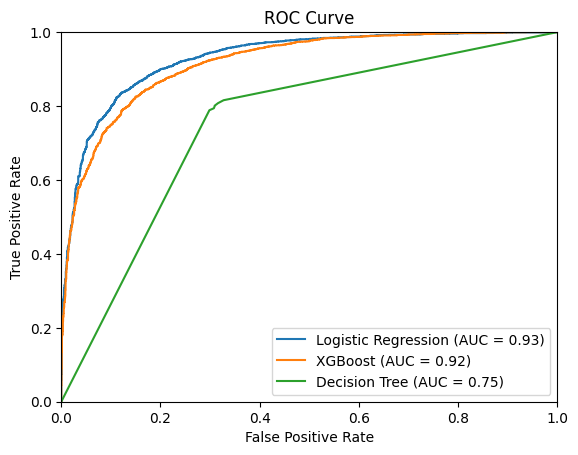

In [47]:
# Plot ROC-AUC curve for Logistic Regression
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.2f)' % roc_auc_lr)

# Plot ROC-AUC curve for XGBoost
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)

# Plot ROC-AUC curve for Decision Tree
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


## **Question 4 : Evaluation and Reporting** (20 pt)

- Select a model that is expected to perform optimally on the unseen data and provide the predicted sentiments accordingly.
- Give clear conclusions.

In [48]:
#  Logistic Regression

y_pred_lr = best_linear_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_lr))
print("classification Report: ", classification_report(y_test, y_pred_lr))

Test Accuracy: 0.8562355658198614
classification Report:                precision    recall  f1-score   support

           0       0.82      0.84      0.83      2200
           1       0.88      0.87      0.87      2996

    accuracy                           0.86      5196
   macro avg       0.85      0.85      0.85      5196
weighted avg       0.86      0.86      0.86      5196



## **Question 5 : External validation** (30 pt)

- A dataset named '`test.csv`' is provided to you in which the sentiment label is hidden.
- You have to choose the best model (the classifier which has the highest ROC-AUC score) and then use that model to predict the probabilities of sentiment on the '`test.csv`'.
- After prediction, you will get a 2D array of probabilities for each sentiment. Select the 2nd column of probabilites for your submission.

```
# Fit
your_best_model = model.fit(x_train)

# Calculate the probabilities of both classes and extract the probabilities of positive class
pred_probabilities = your_best_model.predict_proba(x_test)[:,1]

# Evaluate/Submit
---
```

- Convert that final array into a csv file, name it as '`submission.csv`' and submit that '`submission.csv`' file.

In [49]:
test_df=pd.read_csv('C:\\Users\\kumarip\\Documents\\Priya\\final\\final\\Problem1\\data\\test.csv')
test_df.head()

## Null value treatment
mean_year=test_df['year'].mean()
test_df['year'].fillna(mean_year,inplace=True)


##cleaning the dataset
test_df['user_review_clean'] = test_df['user_review'].apply(clean_text)
test_df['developer_clean'] = test_df['developer'].apply(clean_text)

#stopword removal
test_df['user_review_clean'] = test_df['user_review_clean'].apply(remove_stopwords, args=(tokenizer, stopword_list))
test_df['developer_clean'] = test_df['developer_clean'].apply(remove_stopwords, args=(tokenizer, stopword_list))

#stemming
test_df['user_review_clean'] = test_df['user_review_clean'].apply(stem_text, args=(tokenizer, stopword_list, stemmer))
test_df['developer_clean'] = test_df['developer_clean'].apply(stem_text, args=(tokenizer, stopword_list, stemmer))

In [50]:
#select the required columns
test_df_cols= test_df[['user_review_clean','developer_clean']]
test_df_cols

,user_review_clean,developer_clean
0,rotmg free bullet hellstyl mmorpg unlik mani m...,wild shadow studio deca game
1,team fortress seem like understat say recommen...,valv
2,good tool learn new word easi way learn immit ...,valv
3,present game phenomen varieti card alreadi str...,sparkyp studio llc
4,glad wast k hour game endlessli grind reason o...,trion world
...,...,...
170,quit spectacular game around come dd era find ...,grind gear game
171,realli great game would love donat wonder peop...,wing cloud
172,world gun sayim huge fan gun bigger fan game h...,nobl empir corp
173,earli access reviewhand one best free game get...,blue mammoth game


In [51]:
test_df_cols['combined_text'] = test_df_cols['user_review_clean'] + ' ' + test_df_cols['developer_clean']
test_df_new=test_df_cols['combined_text'] 

C:\Users\kumarip\AppData\Local\Temp\1\ipykernel_23676\1981869061.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_cols['combined_text'] = test_df_cols['user_review_clean'] + ' ' + test_df_cols['developer_clean']


In [52]:
pred=best_linear_model.predict(test_df_new)

In [53]:
pred_probabilities = best_linear_model.predict_proba(test_df_new)[:,1]

# step 5. Save output as csv file
pred_probabilities = pd.DataFrame(pred_probabilities, columns=['PositiveSentimentProbability'])
pred_probabilities.to_csv('./submission.csv', index = False)

## Hint - Final evaluation metrics
- Please use the below function named 'model_evaluation' in order to calculate the evaluation metrics.
- Make sure you submit the probability for each row and not the sentiment
 label itself.

In [ ]:
from sklearn.metrics import roc_auc_score

def model_evaluation(y_test, y_pred):
    # Calculate the roc_auc score
    score = roc_auc_score(y_test, y_pred)

    # Return the score
    print('The ROC_AUC score is : ', score)